## Imports

In [15]:
import platform, numpy as np, pandas as pd, matplotlib.pyplot as plt

from pathlib import Path
from datetime import datetime
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from joblib import dump, load
from src.engineering import EngineerTransformer, DROP_LATER as DROP_LATER_02

## Setup

In [2]:
SEED = 42
np.random.seed(SEED)

DATA_DIR = Path("../data/clean")
OUT_DIR  = Path("../outputs"); OUT_DIR.mkdir(parents=True, exist_ok=True)

print("Python:", platform.python_version())

Python: 3.11.14


## Load latest clean dataset from01

In [3]:
clean_files = sorted(DATA_DIR.glob("train_clean_*.csv"))
assert clean_files, "No cleaned file found in data/clean. Run 01_data_preparation first."
train_clean_csv = clean_files[-1]

df = pd.read_csv(train_clean_csv)
print("Loaded:", train_clean_csv.name, "| shape:", df.shape)

# Target
target = "Survived"
assert target in df.columns, f"Target column '{target}' not found."

Loaded: train_clean_20251019-211325.csv | shape: (891, 12)


## Bring the engineering transformer from 02

In [4]:
DROP_LATER = ["PassengerId","Name","Ticket","Cabin"]  # columns to drop after engineering

engineer_step = None
DROP_LATER = DROP_LATER_02  # keep consistent
engineer_step = EngineerTransformer(drop_cols=DROP_LATER)
print("Using EngineerTransformer from engineering.py")

Using EngineerTransformer from engineering.py


## Define preprocessing (auto-detect numeric vs categorical)

In [5]:
#Preprocessing: automatic column detection after engineering
numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    # control the expansion to avoid feature explosion
    ("ohe", OneHotEncoder(handle_unknown="ignore", min_frequency=0.01)),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, selector(dtype_include=np.number)),
        ("cat", categorical_pipe, selector(dtype_exclude=np.number)),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

print("Preprocess pronto.")

Preprocess pronto.


## Train/test split

In [6]:
# Split, CV, fit, evaluate
X = df.drop(columns=[target])
y = df[target].astype("int64")

strat = y if y.nunique() > 1 else None

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=strat, random_state=SEED
)

## Benchmark: LogisticRegression vs RandomForest

In [7]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
print("Train/Test shapes:", X_train.shape, X_test.shape)

# 1) pipeline genérico (o classificador e o seletor serão definidos via grid)
base_pipe = Pipeline([
    ("engineer", engineer_step),   # do 02
    ("preprocess", preprocess),    # ColumnTransformer (num+cat)
    ("select", "passthrough"),     # por padrão desliga seleção
    ("clf", LogisticRegression())  # placeholder; o grid troca por LR/RF de verdade
])

# 2) grids específicos por modelo
grid_lr = {
    "clf": [LogisticRegression(max_iter=800, solver="liblinear",
                               class_weight="balanced", random_state=SEED)],
    "clf__penalty": ["l1", "l2"],
    "clf__C": [0.5, 1.0, 2.0, 4.0],
    # seleção opcional baseada em LR-L1
    "select": [
        "passthrough",
        SelectFromModel(
            estimator=LogisticRegression(penalty="l1", solver="liblinear",
                                         C=1.0, class_weight="balanced",
                                         random_state=SEED),
            threshold="median",
            prefit=False,
        ),
    ],
}

grid_rf = {
    "clf": [RandomForestClassifier(random_state=SEED, n_jobs=-1)],
    # >>> hiperparâmetros recomendados p/ RF (ponto de partida)
    "clf__n_estimators": [200, 300, 500, 800],
    "clf__max_depth": [None, 8, 16, 24],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4],
    "clf__max_features": ["sqrt", "log2", None],
    "clf__class_weight": [None, "balanced"],
    # seleção antes do RF normalmente fica desligada
    "select": ["passthrough"],
}

# 3) busca única comparando modelos + hiperparâmetros
scoring = {
    "roc_auc": "roc_auc",
    "accuracy": "accuracy",
    "f1": "f1",
    "precision": "precision",
    "recall": "recall"
}

gs = GridSearchCV(
    estimator=base_pipe,
    param_grid=[grid_lr, grid_rf],
    cv=cv,
    scoring=scoring,
    refit="roc_auc",
    n_jobs=-1,
    verbose=1,
)

gs.fit(X_train, y_train)

final_model = gs.best_estimator_
print("Melhor combinação:", gs.best_params_)
print(f"Melhor ROC-AUC (CV): {gs.best_score_:.4f}")
print("Vencedor:", type(final_model.named_steps["clf"]).__name__)
pd.DataFrame(gs.cv_results_)[
    ['param_clf', 'mean_test_roc_auc', 'mean_test_accuracy', 'mean_test_f1']
]


Train/Test shapes: (668, 11) (223, 11)
Fitting 5 folds for each of 880 candidates, totalling 4400 fits


c:\Users\Doglas\miniconda3\envs\titanic-ml\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Melhor combinação: {'clf': RandomForestClassifier(n_jobs=-1, random_state=42), 'clf__class_weight': 'balanced', 'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 10, 'clf__n_estimators': 200, 'select': 'passthrough'}
Melhor ROC-AUC (CV): 0.8696
Vencedor: RandomForestClassifier


,param_clf,mean_test_roc_auc,mean_test_accuracy,mean_test_f1
0,"LogisticRegression(class_weight='balanced', ma...",0.848937,0.784368,0.729419
1,"LogisticRegression(class_weight='balanced', ma...",0.851001,0.785894,0.732645
2,"LogisticRegression(class_weight='balanced', ma...",0.849883,0.782875,0.728244
3,"LogisticRegression(class_weight='balanced', ma...",0.850845,0.787386,0.734111
4,"LogisticRegression(class_weight='balanced', ma...",0.849028,0.782875,0.727945
...,...,...,...,...
875,"RandomForestClassifier(n_jobs=-1, random_state...",0.859058,0.800965,0.738389
876,"RandomForestClassifier(n_jobs=-1, random_state...",0.859249,0.799473,0.737945
877,"RandomForestClassifier(n_jobs=-1, random_state...",0.858938,0.794973,0.732549
878,"RandomForestClassifier(n_jobs=-1, random_state...",0.859416,0.794973,0.731616


## Feature selector

Test ROC-AUC : 0.8451875742658292
Test Accuracy: 0.7937219730941704
Test Precision: 0.7439024390243902
Test Recall   : 0.7093023255813954
Test F1       : 0.7261904761904762


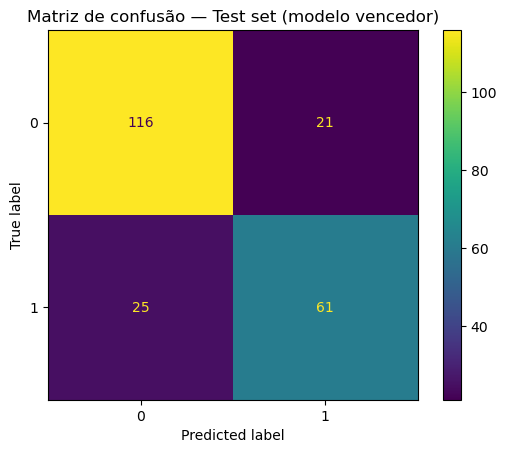

In [8]:
# Avaliação no TEST set — independe do algoritmo vencedor
proba = final_model.predict_proba(X_test)[:, 1]
pred  = (proba >= 0.5).astype(int)

print("Test ROC-AUC :", roc_auc_score(y_test, proba))
print("Test Accuracy:", accuracy_score(y_test, pred))
print("Test Precision:", precision_score(y_test, pred, zero_division=0))
print("Test Recall   :", recall_score(y_test, pred, zero_division=0))
print("Test F1       :", f1_score(y_test, pred, zero_division=0))

ConfusionMatrixDisplay.from_predictions(y_test, pred)
plt.title("Matriz de confusão — Test set (modelo vencedor)")
plt.show()

## Extract selected feature names + importance ranking

In [10]:
# Feature names after preprocessing, and which were selected
pp_names = final_model.named_steps["preprocess"].get_feature_names_out()

# lidar com o passo 'select' (pode ser 'passthrough' ou um seletor)
selector = final_model.named_steps.get("select", "passthrough")

if selector == "passthrough" or selector is None:
    # nenhuma seleção: todas as colunas passaram
    support_mask = np.ones(len(pp_names), dtype=bool)
    selected_names = np.array(pp_names)
elif hasattr(selector, "get_support"):
    support_mask = selector.get_support()
    selected_names = np.array(pp_names)[support_mask]
else:
    # fallback defensivo
    support_mask = np.ones(len(pp_names), dtype=bool)
    selected_names = np.array(pp_names)

# pegar o estimador vencedor
clf = final_model.named_steps["clf"]

# vetor de importância/coefs no espaço "após seleção"
if hasattr(clf, "coef_"):                       # LogisticRegression
    values = np.abs(clf.coef_).ravel()
elif hasattr(clf, "feature_importances_"):      # RandomForest
    values = clf.feature_importances_.ravel()
else:
    raise AttributeError("O estimador vencedor não expõe coef_ nem feature_importances_.")

# montar ranking (o clf foi treinado nas features 'selected_names')
rank_df = (
    pd.DataFrame({"feature": selected_names, "importance": values})
      .sort_values("importance", ascending=False, ignore_index=True)
)

print(f"Selected features: {len(selected_names)} / {len(pp_names)}")
rank_df.head(10)

Selected features: 11 / 11


,feature,importance
0,Sex_male,0.228326
1,Sex_female,0.219859
2,Fare,0.186099
3,Age,0.133509
4,Pclass,0.094917
5,FamilySize,0.050436
6,SibSp,0.028124
7,Parch,0.022881
8,Embarked_S,0.015333
9,Embarked_C,0.014436


## Save artifacts (CSV, PNG, PKL, TXT)

In [13]:
# Persist artifacts
ts = datetime.now().strftime("%Y%m%d-%H%M%S")
base = f"titanic_feature_sel_{ts}"

selected_csv = OUT_DIR / f"{base}_selected_features.csv"
rank_csv     = OUT_DIR / f"{base}_ranking.csv"
plot_png     = OUT_DIR / f"{base}_importance.png"
model_file   = OUT_DIR / "model_best.joblib"
metrics_txt  = OUT_DIR / f"{base}_metrics.txt"

# CSVs
pd.Series(selected_names, name="feature").to_csv(selected_csv, index=False)
rank_df.to_csv(rank_csv, index=False)

# Plot top by |coef|
topk = rank_df.head(20)
plt.figure(figsize=(8, 6))
plt.barh(topk["feature"][::-1], topk["importance"][::-1])
plt.title("Top features by |coef| (final model)")
plt.tight_layout()
plt.savefig(plot_png, dpi=150, bbox_inches="tight")
plt.close()

# full pipeline: engineer + preprocess + select + clf)
dump(final_model, model_file)

# --- Métricas (usa as já calculadas; calcula se faltarem) ---
try:
    test_roc_auc = roc_auc_score(y_test, proba)
    test_accuracy = accuracy_score(y_test, pred)
except NameError:
    proba = final_model.predict_proba(X_test)[:, 1]
    pred  = (proba >= 0.5).astype(int)
    test_roc_auc = roc_auc_score(y_test, proba)
    test_accuracy = accuracy_score(y_test, pred)

# Metrics report
with open(metrics_txt, "w", encoding="utf-8") as f:
    # 'support_mask' e 'pp_names' vêm do bloco anterior; se não existirem, assume tudo selecionado
    if "support_mask" not in globals():
        pp_names = final_model.named_steps["preprocess"].get_feature_names_out()
        support_mask = np.ones(len(pp_names), dtype=bool)

    f.write(f"Selected: {int(np.sum(support_mask))} / {len(pp_names)}\\n")
    f.write(f"Test ROC-AUC: {test_roc_auc:.4f}\\n")
    f.write(f"Test Accuracy: {test_accuracy:.4f}\\n")
    f.write(f"Test Precision: {precision_score(y_test, pred, zero_division=0):.4f}\\n")
    f.write(f"Test Recall: {recall_score(y_test, pred, zero_division=0):.4f}\\n")
    f.write(f"Test F1: {f1_score(y_test, pred, zero_division=0):.4f}\\n")

print("\n===== ARTIFACTS =====")
print("Selected features :", selected_csv)
print("Full ranking      :", rank_csv)
print("Importance plot   :", plot_png)
print("Reduced pipeline  :", model_file)
print("Metrics           :", metrics_txt)



===== ARTIFACTS =====
Selected features : ..\outputs\titanic_feature_sel_20251019-214416_selected_features.csv
Full ranking      : ..\outputs\titanic_feature_sel_20251019-214416_ranking.csv
Importance plot   : ..\outputs\titanic_feature_sel_20251019-214416_importance.png
Reduced pipeline  : ..\outputs\model_best.joblib
Metrics           : ..\outputs\titanic_feature_sel_20251019-214416_metrics.txt


## Quick inference sanity check

In [17]:
# Sanity check that PKL can predict on raw-clean schema
loaded = load(model_file)

# Use a small slice from X_test (raw-clean columns) — engineer step runs inside the pipeline
sample = X_test.head(5).copy()
sample_proba = loaded.predict_proba(sample)[:, 1]
sample_pred  = (sample_proba >= 0.5).astype(int)

pd.DataFrame({"proba": sample_proba, "pred": sample_pred})


,proba,pred
0,0.202563,0
1,0.867027,1
2,0.474328,0
3,0.860183,1
4,0.091847,0
